# Setting

## Libraries

In [1]:
library(quantmod)
library(forecast)
library(rugarch)

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: parallel


Attaching package: ‘rugarch’


The following object is masked from ‘package:stats’:

    sigma




### user's defined

In [2]:
source("~/works/utils/r/myutils.r")
source("~/works/utils/r/myarimagarch.r")

In [3]:
new.get_result <- function(x, group, group.col='Models',
                          #errors=c('rmse','mape'), # unconditional forecast
                          errors=c('rmse.mean','mape.mean') # daily forecast
                          ) 
{
    y <- my.get_result(x, group, errors=errors, group.col=group.col)
    colnames(y) <- c('rmse','mape',group.col)
    return(y)
}

new.plot_errors <- function(x, group.col='Models', ...) {
    my.plot_errors(x, metrics=c('rmse'), group.col=group.col, ...)
}

## Data

### S&P 500

In [4]:
train_start <- '1991-01-01'
train_end <- '2019-12-31'

test_start <- '2020-01-01'
test_end <- '2020-12-31'

In [5]:
from <- train_start
to <- test_end
getSymbols("^GSPC", from=from, to=to)

[1] "^GSPC"

In [6]:
spx <- GSPC
colnames(spx) <- c('o','h','l','c','v','a')

### Return

In [7]:
lookahead <- 21

In [8]:
spx.ret <- diff(log(spx$a), lookahead)
spx.ret <- na.omit(spx.ret)
colnames(spx.ret) <- 'logret'
head(spx.ret)

               logret
1991-01-31 0.05216129
1991-02-01 0.06360416
1991-02-04 0.08173788
1991-02-05 0.10755822
1991-02-06 0.12847341
1991-02-07 0.13502311

In [9]:
train <- window(spx.ret, end=as.Date(train_end))
test <- window(spx.ret, start=as.Date(test_start), end=as.Date(test_end))

## CV Settings

In [10]:
YEAR <- 252

#hori <- floor(YEAR/2)
#hori <- floor(YEAR/6)
hori <- floor(YEAR/12)

#peri <- floor(hori/2)
#peri <- hori*2
peri <- hori

#wind <- 5*YEAR
#wind <- 7*YEAR
wind <- 9*YEAR

### testing
- rerun Regressors

In [24]:
train_start <- '1991-01-01'
train_end <- '2000-12-31'
#train_end <- '1998-12-31'
#train_end <- '1997-12-31'
train <- window(spx.ret, start=as.Date(train_start), end=as.Date(train_end))

In [25]:
sample.r <- 0.1
#sample.r <- 0.05

n <- (nrow(train) - wind - hori)/floor(peri) * round(hori * sample.r)
print(paste('number of iterations: ', round(n), sep=''))

[1] "number of iterations: 21"


## Regressors

In [26]:
x <- RSI(spx$a)
trainx <- merge(train, x, join='left', fill=NA)

In [27]:
# use close instead of adjusted to make consistent with "un-adjusted" high & low
x <- BBands(spx[,c('h','l','c')])
x <- x$pctB
trainx <- merge(trainx, x, join='left', fill=NA)

In [28]:
x <- MACD(spx$a)
x <- x$macd - x$signal
trainx <- merge(trainx, x, join='left', fill=NA)

In [29]:
colnames(trainx) <- c('y','rsi','bbands','macd')
trainx <- na.omit(trainx)
head(trainx)
tail(trainx)

                    y      rsi    bbands        macd
1991-02-19 0.10602550 72.59254 0.8419486 -0.03641515
1991-02-20 0.09798126 66.25313 0.7706927 -0.18551057
1991-02-21 0.10585688 66.00481 0.7330987 -0.30953562
1991-02-22 0.10194779 66.54491 0.7402938 -0.39546732
1991-02-25 0.09259647 67.84742 0.7305630 -0.43573971
1991-02-26 0.07655978 60.80133 0.6379610 -0.55105032

                      y      rsi      bbands        macd
2000-12-21 -0.055303326 35.58279 -0.08118867 -0.52657176
2000-12-22 -0.012487300 43.27857  0.16850774 -0.39482896
2000-12-26 -0.020008556 45.36756  0.31665756 -0.23687015
2000-12-27 -0.014974701 48.40815  0.43464789 -0.04835247
2000-12-28 -0.001400583 49.57479  0.50613909  0.10877207
2000-12-29 -0.016265059 46.59058  0.45131826  0.14487942

# Prophet

## Setting

In [12]:
library(prophet)
library(dplyr)

Loading required package: Rcpp

Loading required package: rlang


Attaching package: ‘dplyr’


The following objects are masked from ‘package:xts’:

    first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [18]:
cv.forecast <- function(x, h, xreg=NULL, xreg.msize=NULL) {
    
    check.ds <- function(x) {
        d <- try(as.POSIXct(x$ds, format = "%Y-%m-%d"), silent=T)
        if ((sum(is.na(d))>0) | (is.element("try-error", class(d))))  {
            #print("That wasn't correct!")
            x$ds <- seq(as.Date('1901-01-01'), length.out=length(x$ds), by=1)
        }
        return(x)
    }
    
    model <- prophet()

    if (!is.null(xreg)) {
        ### convert data for prophet
        #x <- ifelse(is.null(dim(x)), data.frame(x), x) # not works
        if (is.null(dim(x))) {x <- data.frame(x)}
        colnames(x) <- 'y'
        x.train <- cbind(x, xreg)
        x.train <- as.data.frame(x.train)
        x.train <- cbind(ds=rownames(x.train), x.train)
        rownames(x.train) <- NULL
        x.train <- check.ds(x.train)

        ### add regressors before fitting
        for (c in colnames(xreg)) {
            model <- add_regressor(model, c)
        }

        ### fit: must run after add_regressor and before make_future_dataframe
        model <- fit.prophet(model, x.train)

        ### prepare future ds
        future <- make_future_dataframe(model, periods=h)

        # regessor assumption for future
        if (is.null(xreg.msize)) {
            xreg.m <- xreg # calc mean for future with all the xreg
        } else {
            # calc mean for future with xreg of length xreg.mszie
            xreg.m <- tail(xreg, n=xreg.msize)
        }
        
        if (is.null(dim(xreg))) {
            xreg.h <- mean(xreg.m)
        } else {
            xreg.h <- colMeans(xreg.m)  
        }

        # rbind history & future of xreg
        xreg.all <- data.frame(xreg)
        xreg.coln <- colnames(xreg.all) # save name for the case of single xreg

        xreg.h <- data.frame(xreg.h)
        colnames(xreg.h) <- colnames(NA)
        xreg.h <- t(xreg.h)
        xreg.h <- as.ts(xreg.h[rep(seq_len(nrow(xreg.h)), h), ])
        xreg.h <- data.frame(xreg.h) # convert to frame for the case of single xreg
        
        # update future
        if ((dim(xreg.h)[2]==1) & (dim(xreg.h)[1]==length(xreg.coln))) {
            xreg.h <- t(xreg.h) # the case of h==1
        }
        colnames(xreg.h) <- xreg.coln # match name to rbind
        #xreg.all <- rbind(xreg.all, xreg.h)
        xreg.all <- rbind(as.matrix(xreg.all), xreg.h) 
        xreg.all <- data.frame(xreg.all, row.names = NULL) 
        xreg.all$ds <- future$ds
        future <- xreg.all

    } else {
        x.train <- data.frame(ds=index(x), y=as.numeric(x))
        x.train <- check.ds(x.train)
        model <- fit.prophet(model, x.train)
        future <- make_future_dataframe(model, periods=h)
    }

    fc <- predict(model, future)
    fc <- list(method = "Prophet Forecasting", mean=tail(fc$yhat, h))
    return(fc)
} 

In [19]:
# main difference with cv.forecast is that cv.forecase.2 need data for forecasting
cv.forecast.2 <- function(x, h, xreg=NULL, xreg.msize=NULL, sample.n=0) 
{
    result.rmse <- c()
    result.mape <- c()
    train.len <- length(x) - h
    my.subset <- function(x, s, e) {
        if (!is.null(x)) {
            #x <- subset(x, start=s, end=e)
            #x <- subset(as.ts(x), start=s, end=e)
            x <- subset(ts(x), start=s, end=e)
        }
        return(x)
    }
    idx <- 0:(h-1)
    if ((sample.n>0) & (sample.n<h)) {
        idx <- sort(sample(idx, sample.n))
    }
    for (i in seq_along(idx)) {
        trlen <- train.len+idx[i]
        x.train <- my.subset(x, 1, trlen)
        xreg.train <- my.subset(xreg, 1, trlen)
        fc <- cv.forecast(x.train, 1, xreg=xreg.train, xreg.msize=xreg.msize)
        result.rmse[i] <- sqrt(mean((fc$mean - x[trlen+1])^2))
        result.mape[i] <- mean(abs(1 - fc$mean / x[trlen+1]))
    }
    e <- list(rmse.mean=mean(result.rmse), rmse.sigma=sd(result.rmse), 
              mape.mean=mean(result.mape), mape.sigma=sd(result.mape))
    return(e)
} 

## Basic

In [20]:
result.m01.1 <- my.tsCV.2(train, cv.forecast.2, h=hori, window=wind, step=peri,
                          silent=F,
                          sample.n=round(hori*sample.r))

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "10 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "20 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "30 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "40 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "50 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "60 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "70 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "80 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "90 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

In [21]:
x <- result.m01.1
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 2000-01-24"


## Additional regressors

In [22]:
result.m01.2 <- my.tsCV.2(trainx[,1], cv.forecast.2, h=hori, window=wind, step=peri,
                          xreg=trainx[,2:4], 
                          sample.n=round(hori*sample.r),
                          silent=F)

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "10 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "20 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "30 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "40 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "50 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "60 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "70 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "80 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "90 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

In [23]:
result.m01.3 <- my.tsCV.2(trainx[,1], cv.forecast.2, h=hori, window=wind, step=peri,
                          xreg=trainx[,3], 
                          silent=F,
                          sample.n=round(hori*sample.r))

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "10 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "20 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "30 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "40 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "50 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "60 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "70 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "80 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "90 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

In [24]:
result.m01.4 <- my.tsCV.2(trainx[,1], cv.forecast.2, h=hori, window=wind, step=peri,
                         xreg=trainx[,2:4], 
                         sample.n=round(hori*sample.r),
                         xreg.msize=hori)

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "10 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "20 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "30 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "40 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "50 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "60 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "70 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "80 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

[1] "90 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

Disabling daily seasonality. Run

## Compare Errors

In [18]:
my.figsize(10,6)

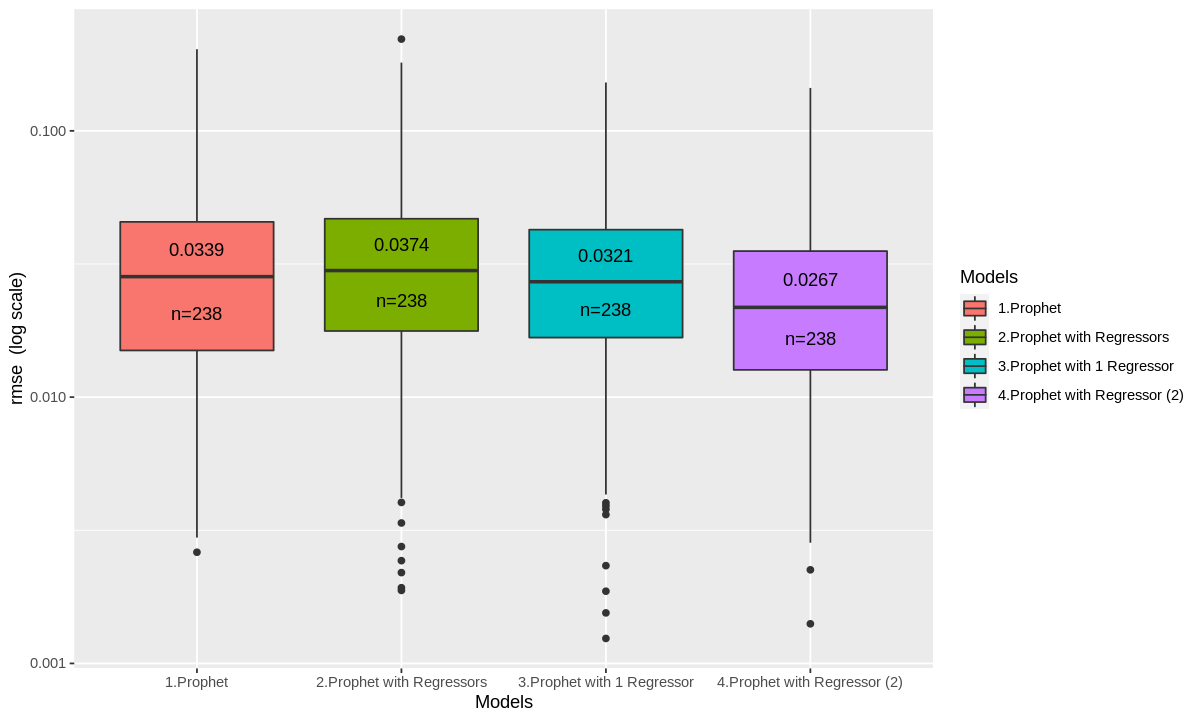

In [19]:
errors.1 <- new.get_result(result.m01.1, '1.Prophet')
errors.2 <- new.get_result(result.m01.2, '2.Prophet with Regressors')
errors.3 <- new.get_result(result.m01.3, '3.Prophet with 1 Regressor')
errors.4 <- new.get_result(result.m01.4, '4.Prophet with Regressor (2)')

x <- rbind(errors.1, errors.2)
x <- rbind(x, errors.3)
x <- rbind(x, errors.4)
new.plot_errors(x, ylog=T)

### save result

In [ ]:
x <- result.m01.1
write.csv(x, file = "prophet_result_m0101.csv")
x <- result.m01.2
write.csv(x, file = "prophet_result_m0102.csv")
x <- result.m01.3
write.csv(x, file = "prophet_result_m0103.csv")
x <- result.m01.4
write.csv(x, file = "prophet_result_m0104.csv")

### load result

In [16]:
result.m01.1 <- read.csv(file = 'prophet_result_m0101.csv')
result.m01.2 <- read.csv(file = 'prophet_result_m0102.csv')
result.m01.3 <- read.csv(file = 'prophet_result_m0103.csv')
result.m01.4 <- read.csv(file = 'prophet_result_m0104.csv')

In [51]:
result.m01 <- result.m01.4

# BSTS

## Setting

In [30]:
library(bsts)

Loading required package: BoomSpikeSlab

Loading required package: Boom

Loading required package: MASS


Attaching package: ‘Boom’


The following object is masked from ‘package:stats’:

    rWishart



Attaching package: ‘BoomSpikeSlab’


The following object is masked from ‘package:stats’:

    knots



Attaching package: ‘bsts’


The following object is masked from ‘package:BoomSpikeSlab’:

    SuggestBurn




In [31]:
cv.forecast <- function(x, h, xreg=NULL, xreg.msize=NULL, expected.model.size=NULL) {
    
    if (!is.null(xreg)) {
        ### convert data for bsts
        if (is.null(dim(x))) {x <- data.frame(x)}
        colnames(x) <- 'y'
        x.train <- cbind(x, xreg)
        x.train <- as.data.frame(x.train)
        
        ### fitting
        n <- ncol(x.train)
        if (is.null(expected.model.size)) {
            expected.model.size <- n
        } else if (expected.model.size > n) {
            expected.model.size <- n
        }
        ss <- AddSemilocalLinearTrend(list(), x.train$y)
        model <- bsts(y ~ .,
                      state.specification = ss,
                      niter = 1000,
                      data = x.train,
                      expected.model.size = expected.model.size)  # Passed to SpikeSlabPrior.
        
        ### prepare future of xreg for prediction
        # regessor assumption for future
        if (is.null(xreg.msize)) {
            xreg.m <- xreg # calc mean for future with all the xreg
        } else {
            # calc mean for future with xreg of length xreg.mszie
            xreg.m <- tail(xreg, n=xreg.msize)
        }

        if (is.null(dim(xreg))) {
            xreg.h <- mean(xreg.m)
        } else {
            xreg.h <- colMeans(xreg.m)  
        }

        xreg.all <- data.frame(xreg)
        xreg.coln <- colnames(xreg.all) # save name for the case of single xreg
        xreg.h <- data.frame(xreg.h)
        colnames(xreg.h) <- colnames(NA)
        xreg.h <- t(xreg.h)
        xreg.h <- as.ts(xreg.h[rep(seq_len(nrow(xreg.h)), h), ])
        xreg.h <- data.frame(xreg.h) # convert to frame for the case of single xreg
        colnames(xreg.h) <- xreg.coln # match name to rbind

    } else {
        ss <- AddSemilocalLinearTrend(list(), x)
        model <- bsts(x, state.specification = ss, niter=1000)
        xreg.h <- NULL
    }
    
    fc <- predict(model, horizon=h, newdata=xreg.h)
    return(fc)
} 

## Basic

In [32]:
result.m02.1 <- my.tsCV(train, cv.forecast, h=hori, window=wind, step=peri)

=-=-=-=-= Iteration 0 Wed Sep 21 08:22:30 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Wed Sep 21 08:22:33 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Wed Sep 21 08:22:36 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Wed Sep 21 08:22:39 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Wed Sep 21 08:22:42 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Wed Sep 21 08:22:45 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Wed Sep 21 08:22:47 2022 =-=-=-=-=
=-=-=-=-= Iteration 700 Wed Sep 21 08:22:50 2022 =-=-=-=-=
=-=-=-=-= Iteration 800 Wed Sep 21 08:22:53 2022 =-=-=-=-=
=-=-=-=-= Iteration 900 Wed Sep 21 08:22:56 2022 =-=-=-=-=
[1] "8 % done."
=-=-=-=-= Iteration 0 Wed Sep 21 08:22:59 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Wed Sep 21 08:23:02 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Wed Sep 21 08:23:06 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Wed Sep 21 08:23:09 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Wed Sep 21 08:23:12 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Wed Sep 21 08:23:15 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Wed Sep 21 08:23:19 

In [33]:
x <- result.m02.1
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 2000-01-24"


## IMPLEMENT

model이 주어지면 fitting 없이 예측할 수 있도록 수정.
각 cv iter에 대하여 첫회만 fitting해 model구하고 이후는 predict에 model을 제공하면 되나?
그런데 predict에 변경된 데이터를 입력할 방법이 있나? 결국 데이터가 변경되었으니 model도 새로 만들어야 하나?
그렇다고 추가 데이터 하나에 대해 mcmc 수행은 비효율적. 뭔가 첫회 수행한 결과를 사용할수 없나?
예를 들어 arima의 경우 첫회에 대해서만 auto.arima 수행해 p,d,q를 구하고 이후에는 이를 사용해 새 데이터에 대해예측을 했음

In [ ]:
cv.forecast <- function(x, h, xreg=NULL, xreg.msize=NULL, expected.model.size=NULL) {
    
    if (!is.null(xreg)) {
        ### convert data for bsts
        if (is.null(dim(x))) {x <- data.frame(x)}
        colnames(x) <- 'y'
        x.train <- cbind(x, xreg)
        x.train <- as.data.frame(x.train)
        
        ### fitting
        n <- ncol(x.train)
        if (is.null(expected.model.size)) {
            expected.model.size <- n
        } else if (expected.model.size > n) {
            expected.model.size <- n
        }
        ss <- AddSemilocalLinearTrend(list(), x.train$y)
        model <- bsts(y ~ .,
                      state.specification = ss,
                      niter = 1000,
                      data = x.train,
                      expected.model.size = expected.model.size)  # Passed to SpikeSlabPrior.
        
        ### prepare future of xreg for prediction
        # regessor assumption for future
        if (is.null(xreg.msize)) {
            xreg.m <- xreg # calc mean for future with all the xreg
        } else {
            # calc mean for future with xreg of length xreg.mszie
            xreg.m <- tail(xreg, n=xreg.msize)
        }

        if (is.null(dim(xreg))) {
            xreg.h <- mean(xreg.m)
        } else {
            xreg.h <- colMeans(xreg.m)  
        }

        xreg.all <- data.frame(xreg)
        xreg.coln <- colnames(xreg.all) # save name for the case of single xreg
        xreg.h <- data.frame(xreg.h)
        colnames(xreg.h) <- colnames(NA)
        xreg.h <- t(xreg.h)
        xreg.h <- as.ts(xreg.h[rep(seq_len(nrow(xreg.h)), h), ])
        xreg.h <- data.frame(xreg.h) # convert to frame for the case of single xreg
        colnames(xreg.h) <- xreg.coln # match name to rbind

    } else {
        ss <- AddSemilocalLinearTrend(list(), x)
        model <- bsts(x, state.specification = ss, niter=1000)
        xreg.h <- NULL
    }
    
    fc <- predict(model, horizon=h, newdata=xreg.h)
    return(fc)
} 

In [ ]:
# main difference with cv.forecast is that cv.forecase.2 need data for forecasting
cv.forecast.2 <- function(x, h, xreg=NULL, xreg.msize=NULL, sample.n=0) 
{
    result.rmse <- c()
    result.mape <- c()
    train.len <- length(x) - h
    my.subset <- function(x, s, e) {
        if (!is.null(x)) {
            x <- subset(ts(x), start=s, end=e)
        }
        return(x)
    }
    idx <- 0:(h-1)
    if ((sample.n>0) & (sample.n<h)) {
        idx <- sort(sample(idx, sample.n))
    }
    
    order <- NULL
    for (i in seq_along(idx)) {
        trlen <- train.len+idx[i]
        x.train <- my.subset(x, 1, trlen)
        xreg.train <- my.subset(xreg, 1, trlen)
        
        fc <- cv.forecast(x.train, 1, xreg=xreg.train, xreg.msize=xreg.msize,
                          order=order)
        if (i==1) { # reuse param for the rest of periods
            p <- fc$model$arma[1]
            d <- fc$model$arma[6]
            q <- fc$model$arma[2]
            order <- c(p, d, q)
        }
        
        result.rmse[i] <- sqrt(mean((fc$mean - x[trlen+1])^2))
        result.mape[i] <- mean(abs(1 - fc$mean / x[trlen+1]))
    }
    e <- list(rmse.mean=mean(result.rmse), rmse.sigma=sd(result.rmse), 
              mape.mean=mean(result.mape), mape.sigma=sd(result.mape))
    return(e)
} 

## IMPLEMENT ENDS

## Regression with spike and slab priors

In [27]:
result.m02.2 <- my.tsCV(trainx[,1], cv.forecast, h=hori, window=wind, step=peri,
                       xreg=trainx[,2:4], silent=F)

=-=-=-=-= Iteration 0 Thu Sep 15 18:33:44 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Thu Sep 15 18:33:47 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Thu Sep 15 18:33:50 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Thu Sep 15 18:33:52 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Thu Sep 15 18:33:55 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Thu Sep 15 18:33:58 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Thu Sep 15 18:34:01 2022 =-=-=-=-=
=-=-=-=-= Iteration 700 Thu Sep 15 18:34:04 2022 =-=-=-=-=
=-=-=-=-= Iteration 800 Thu Sep 15 18:34:07 2022 =-=-=-=-=
=-=-=-=-= Iteration 900 Thu Sep 15 18:34:10 2022 =-=-=-=-=
=-=-=-=-= Iteration 0 Thu Sep 15 18:34:13 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Thu Sep 15 18:34:16 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Thu Sep 15 18:34:18 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Thu Sep 15 18:34:21 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Thu Sep 15 18:34:24 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Thu Sep 15 18:34:27 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Thu Sep 15 18:34:30 2022 =-=-=-=-=
=

## Compare Errors

In [28]:
my.figsize(10,6)

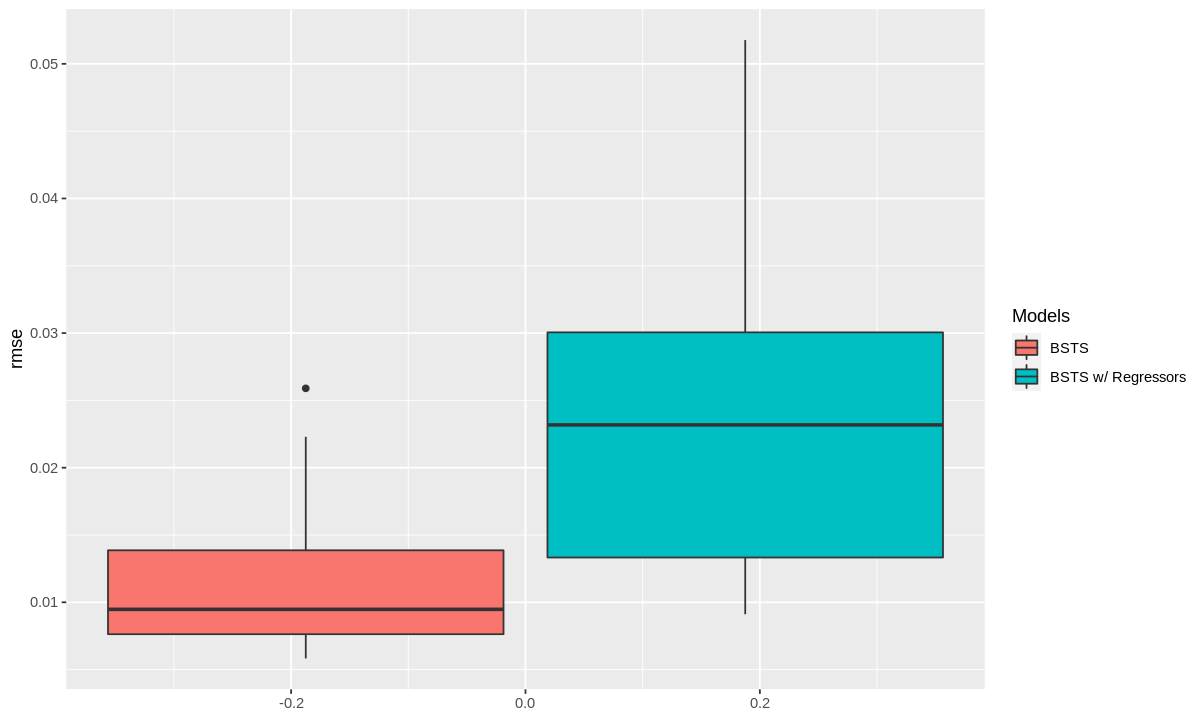

In [29]:
errors.1 <- my.get_result(result.m02.1, 'BSTS')
errors.2 <- my.get_result(result.m02.2, 'BSTS w/ Regressors')

x <- rbind(errors.1, errors.2)

my.plot_errors(x, metrics=c('rmse'), loc='right')

In [54]:
result.m02 <- result.m02.1

# ARIMA

## Setting

In [17]:
cv.forecast <- function(x, h, xreg=NULL, xreg.msize=NULL, order=NULL) {
    
    if (!is.null(xreg)) {
        
        if (is.null(xreg.msize)) {
            xreg.m <- xreg # calc mean for future with all the xreg
        } else {
            # calc mean for future with xreg of length xreg.mszie
            xreg.m <- tail(xreg, n=xreg.msize)
        }
        
        if (is.null(dim(xreg))) {
            xreg.h <- mean(xreg.m)
        } else {
            xreg.h <- colMeans(xreg.m)  
        }
        
        xreg.h <- data.frame(xreg.h)
        colnames(xreg.h) <- colnames(NA)
        #colnames(xreg.h) <- colnames(xreg) # error with multiple xreg
        xreg.h <- t(xreg.h)
        xreg.h <- as.ts(xreg.h[rep(seq_len(nrow(xreg.h)), h), ])
        
        ## added for single day forecast
        xreg.coln <- colnames(xreg)
        xreg.h <- data.frame(xreg.h) # convert to frame for the case of single xreg
        if ((dim(xreg.h)[2]==1) & (dim(xreg.h)[1]==length(xreg.coln))) {
            xreg.h <- t(xreg.h) # the case of h==1
        } else {
            xreg.h <- as.ts(xreg.h) # convert to ts as xreg is ts
        }
        
    } else {
        xreg.h <- NULL
    }
    if (is.null(order)) {
        fc <- forecast(auto.arima(x, trace=TRUE, ic='aicc', seasonal=FALSE, 
                                  xreg=xreg, 
                                  #lambda="auto" # not for negative value
                                  ), h=h, xreg=xreg.h)
    } else {
        fc <- forecast(Arima(x, order=order, seasonal=FALSE, 
                                  xreg=xreg, 
                                  ), h=h, xreg=xreg.h)
    }
    return(fc)
}

In [18]:
# main difference with cv.forecast is that cv.forecase.2 need data for forecasting
cv.forecast.2 <- function(x, h, xreg=NULL, xreg.msize=NULL, sample.n=0) 
{
    result.rmse <- c()
    result.mape <- c()
    train.len <- length(x) - h
    my.subset <- function(x, s, e) {
        if (!is.null(x)) {
            #x <- subset(x, start=s, end=e)
            #x <- subset(as.ts(x), start=s, end=e)
            x <- subset(ts(x), start=s, end=e)
        }
        return(x)
    }
    idx <- 0:(h-1)
    if ((sample.n>0) & (sample.n<h)) {
        idx <- sort(sample(idx, sample.n))
    }
    
    order <- NULL
    for (i in seq_along(idx)) {
        trlen <- train.len+idx[i]
        x.train <- my.subset(x, 1, trlen)
        xreg.train <- my.subset(xreg, 1, trlen)
        
        fc <- cv.forecast(x.train, 1, xreg=xreg.train, xreg.msize=xreg.msize,
                          order=order)
        if (i==1) { # reuse param for the rest of periods
            p <- fc$model$arma[1]
            d <- fc$model$arma[6]
            q <- fc$model$arma[2]
            order <- c(p, d, q)
        }
        
        result.rmse[i] <- sqrt(mean((fc$mean - x[trlen+1])^2))
        result.mape[i] <- mean(abs(1 - fc$mean / x[trlen+1]))
    }
    e <- list(rmse.mean=mean(result.rmse), rmse.sigma=sd(result.rmse), 
              mape.mean=mean(result.mape), mape.sigma=sd(result.mape))
    return(e)
} 

## Basic

In [19]:
result.m03.1 <- my.tsCV.2(train, cv.forecast.2, h=hori, window=wind, step=peri, silent=T)


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : Inf
 ARIMA(0,0,0) with non-zero mean : -8729.901
 ARIMA(1,0,0) with non-zero mean : -13486.9
 ARIMA(0,0,1) with non-zero mean : -10820.55
 ARIMA(0,0,0) with zero mean     : -8407.697
 ARIMA(2,0,0) with non-zero mean : -13491.63
 ARIMA(3,0,0) with non-zero mean : -13491.75
 ARIMA(4,0,0) with non-zero mean : -13496.44
 ARIMA(5,0,0) with non-zero mean : -13502.01
 ARIMA(5,0,1) with non-zero mean : -13509.96
 ARIMA(4,0,1) with non-zero mean : -13504.29
 ARIMA(5,0,2) with non-zero mean : -13507.99
 ARIMA(4,0,2) with non-zero mean : -13508.66
 ARIMA(5,0,1) with zero mean     : -13497.02

 Now re-fitting the best model(s) without approximations...

 ARIMA(5,0,1) with non-zero mean : -13497.21

 Best model: ARIMA(5,0,1) with non-zero mean 


 Fitting models using approximations to speed things up...

 ARIMA(2,1,2) with drift         : Inf
 ARIMA(0,1,0) with drift         : -13377.54
 ARIMA(1,1,0) wi

In [20]:
x <- result.m03.1
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 2000-01-24"


## Regression with ARIMA errors

In [21]:
result.m03.2 <- my.tsCV.2(trainx[,1], cv.forecast.2, h=hori, window=wind, step=peri,
                      silent=F,
                      xreg=trainx[,2:4])


 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : -14728.24
 Regression with ARIMA(0,1,0) errors : -14705.76
 Regression with ARIMA(1,1,0) errors : -14703.21
 Regression with ARIMA(0,1,1) errors : -14703.85
 Regression with ARIMA(0,1,0) errors : -14707.74
 Regression with ARIMA(1,1,2) errors : -14755.07
 Regression with ARIMA(0,1,2) errors : -14703.58
 Regression with ARIMA(1,1,1) errors : -14701.2
 Regression with ARIMA(1,1,3) errors : -14756.2
 Regression with ARIMA(0,1,3) errors : -14715.69
 Regression with ARIMA(2,1,3) errors : -14743.68
 Regression with ARIMA(1,1,4) errors : -14754.84
 Regression with ARIMA(0,1,4) errors : -14713.96
 Regression with ARIMA(2,1,4) errors : -14742.53
 Regression with ARIMA(1,1,3) errors : -14757.92
 Regression with ARIMA(0,1,3) errors : -14717.66
 Regression with ARIMA(1,1,2) errors : -14756.77
 Regression with ARIMA(2,1,3) errors : -14745.4
 Regression with ARIMA(1,1,4) errors : -14756.51
 Regression

In [22]:
x <- result.m03.2
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 2000-01-24"


## Regressor mean of smaller period for forecast 
- Regressor mean for forecast is calculated from the number of latest 'horizon' period
- the 1st model used the number of latest 'window' period for the calc of regressor mean

In [23]:
result.m03.3 <- my.tsCV.2(trainx[,1], cv.forecast.2, h=hori, window=wind, step=peri,
                      xreg.msize=hori,
                      xreg=trainx[,2:4])


 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : -14728.24
 Regression with ARIMA(0,1,0) errors : -14705.76
 Regression with ARIMA(1,1,0) errors : -14703.21
 Regression with ARIMA(0,1,1) errors : -14703.85
 Regression with ARIMA(0,1,0) errors : -14707.74
 Regression with ARIMA(1,1,2) errors : -14755.07
 Regression with ARIMA(0,1,2) errors : -14703.58
 Regression with ARIMA(1,1,1) errors : -14701.2
 Regression with ARIMA(1,1,3) errors : -14756.2
 Regression with ARIMA(0,1,3) errors : -14715.69
 Regression with ARIMA(2,1,3) errors : -14743.68
 Regression with ARIMA(1,1,4) errors : -14754.84
 Regression with ARIMA(0,1,4) errors : -14713.96
 Regression with ARIMA(2,1,4) errors : -14742.53
 Regression with ARIMA(1,1,3) errors : -14757.92
 Regression with ARIMA(0,1,3) errors : -14717.66
 Regression with ARIMA(1,1,2) errors : -14756.77
 Regression with ARIMA(2,1,3) errors : -14745.4
 Regression with ARIMA(1,1,4) errors : -14756.51
 Regression

In [24]:
x <- result.m03.3
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 2000-01-24"


## Compare Errors

In [25]:
my.figsize(10,6)

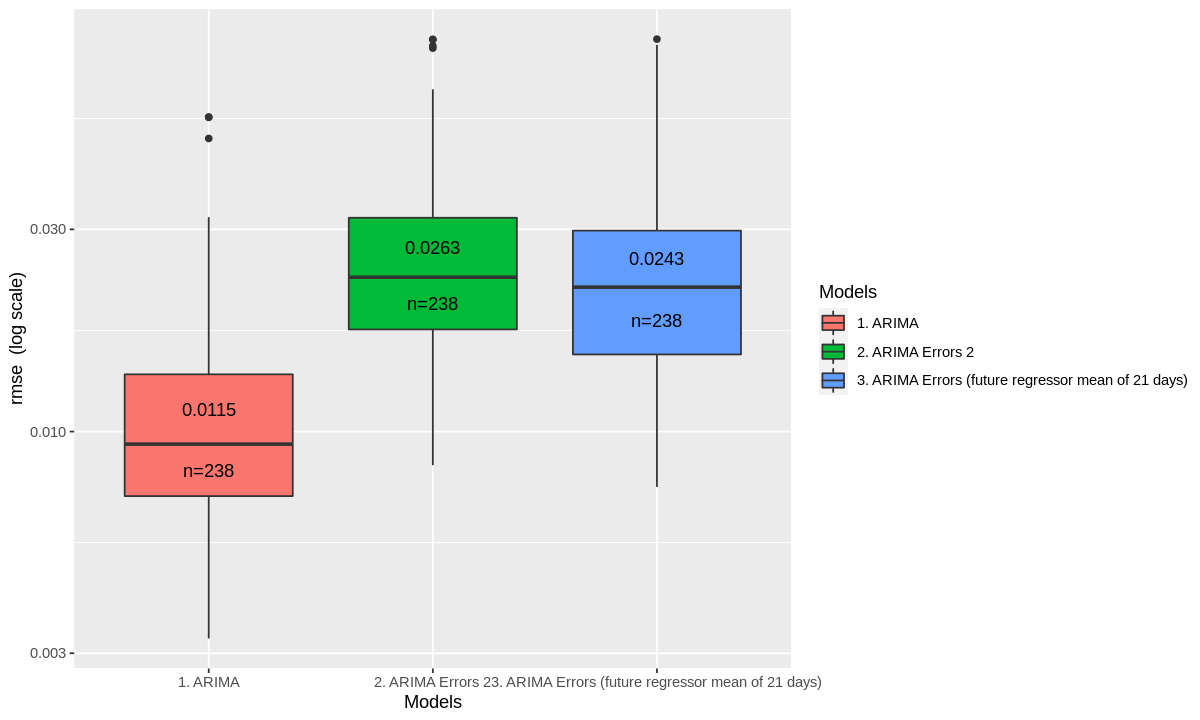

In [23]:
errors.1 <- new.get_result(result.m03.1, '1. ARIMA')
errors.2 <- new.get_result(result.m03.2, '2. ARIMA Errors 2')
n <- paste('3. ARIMA Errors (future regressor mean of', hori ,'days)', sep=' ')
errors.3 <- new.get_result(result.m03.3, n)

x <- rbind(errors.1, errors.2)
x <- rbind(x, errors.3)

new.plot_errors(x, ylog=T)

### save result

In [27]:
x <- result.m03.1
write.csv(x, file = "arima_result_m0301.csv")
x <- result.m03.2
write.csv(x, file = "arima_result_m0302.csv")
x <- result.m03.3
write.csv(x, file = "arima_result_m0303.csv")

### load result

In [21]:
result.m03.1 <- read.csv(file = 'arima_result_m0301.csv')
result.m03.2 <- read.csv(file = 'arima_result_m0302.csv')
result.m03.3 <- read.csv(file = 'arima_result_m0303.csv')

In [52]:
result.m04 <- result.m04.3
#errors.m03 <- errors.m03.3

# ARIMA+GARCH

In [44]:
cv.forecast <- function(x, h) {
    forc <- ag2.forecast(x, h, out.sample=0)
    if (!is.na(forc)) {
        fc <- list(method = "ARIMA+GARCH Forecasting", mean=forc@forecast$seriesFor[,1])
        attr(fc$mean, "names") <- NULL
        return(fc)
    }
}

In [45]:
result.m05 <- my.tsCV(train, cv.forecast, h=hori, window=wind, step=peri)

[1] "12 % done."
[1] "23 % done."
[1] "35 % done."
[1] "46 % done."
[1] "58 % done."
[1] "69 % done."
[1] "81 % done."
[1] "92 % done."


In [46]:
x <- result.m05
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 1997-12-31"


# Gradient Boosting

## Setting

In [94]:
library(xgboost)

In [95]:
xgb.eval <- function(
    train.label, train.features, test.label, test.features,
    nrounds = 1000, early_stopping_rounds = 3,
    max_depth = 6, 
    eta = 0.3, # learning rate
    # In linear regression task, this simply corresponds to minimum number of instances needed to be in each node. 
    # The larger min_child_weight is, the more conservative the algorithm will be. range: [0,∞]
    #min_child_weight = 1 ,
    # Minimum loss reduction required to make a further partition on a leaf node of the tree. 
    # The larger gamma is, the more conservative the algorithm will be. range: [0,∞]
    #gamma = 0,
    verbose=1
) 
{
    if (is.null(dim(test.features))) {
        # conver to matrix for the case of 1 day prediction
        test.features <- t(test.features)
    }
    model <- xgboost(data = train.features,
                     label = train.label,
                     nrounds = nrounds,
                     objective = "reg:squarederror",
                     early_stopping_rounds = early_stopping_rounds,
                     max_depth = max_depth,
                     eta = eta,
                     verbose=verbose)

    pred <- predict(model, test.features)
    # calc errors
    rmse <- sqrt(mean((pred - test.label)^2))
    mape <- mean(abs(1 - pred / test.label))
    result <- list('rmse'=rmse, 'mape'=mape)
    return(result)
}


xgb.gridsearch <- function(label, features, test.h, hyper_grid, verbose=1) {
    len <- length(label)
    idx.train <- 1:(len-test.h)
    idx.test <- (len-test.h+1):(len)
    train.label <- label[idx.train]
    train.features <- features[idx.train,]
    test.label <- label[idx.test]
    test.features <- features[idx.test,]
    
    xgb_test_rmse <- NULL
    xgb_test_mape <- NULL

    for (j in 1:nrow(hyper_grid)) {
        #set.seed(123)
        
        errors <- xgb.eval(train.label, train.features, test.label, test.features,
                            nrounds = 1000, early_stopping_rounds = 3,
                            max_depth = hyper_grid$max_depth[j], 
                            eta = hyper_grid$eta[j],
                            verbose=0)
        # calc errors
        xgb_test_rmse[j] <- errors$rmse
        xgb_test_mape[j] <- errors$mape
    }

    #ideal hyperparamters
    r <- hyper_grid[which.min(xgb_test_rmse), ]
    if (verbose>0) {
        print(r)
    }
    return(r)
}


xgb.tsCV <- function (label, features, max_depth = 6, eta = .25,
                      h = 1, window = NULL, initial = 0, step = 1, 
                      count.freq=0.1, ...) 
{
    y <- as.ts(label)
    n <- length(y)
    step <- round(step)
    step_ind <- seq(step, n - 1L, by = step)

    if (initial >= n) 
        stop("initial period too long")

    xreg <- ts(as.matrix(features))
    if (NROW(xreg) != length(y)) 
        stop("features must be of the same size as label")
    tsp(xreg) <- tsp(y)
 
    if (is.null(window)) {
        indx <- seq(1 + initial, n - 1L)
    } else {
        indx <- seq(window + initial, n - 1L, by = 1L)
    }
    indx <- intersect(indx, step_ind)

    e.cols <- c('forecast_start', 'forecast_end', 'rmse', 'mape')
    e <- ts(matrix(NA_real_, nrow = floor(n/step), ncol = length(e.cols)))
    colnames(e) <- e.cols
    
    ###
    hyper_grid <- expand.grid(max_depth = max_depth, eta = eta)
    if (nrow(hyper_grid)>1) {
        hyper_grid.flag <- TRUE
    } else {
        hyper_grid.flag <- FALSE
    }
    

    cnt <- 0
    print.when <- seq(0, length(indx), by=round(count.freq*length(indx)))
    for (i in indx) {
        # get new start of subset of y & xreg
        if (is.null(window)) {
            start <- 1L
        } else {
            if (i - window >= 0L) {
                start <- i - window + 1L
            } else {
                stop("small window")
            }
        }
        train.label <- subset(y, start=start, end = i)
        train.features <- as.matrix(subset(xreg, start=start, end=i))
        
        # get test data
        start <- i+1
        end <- i+h
        if (end <= nrow(xreg)) {
            test.label <- subset(y, start=start, end=end)
            test.features <- as.matrix(subset(xreg, start=start, end=end))
        } else {
            next
        }
        
        # tune hyperparams
        if (hyper_grid.flag) {
            res <- xgb.gridsearch(train.label, train.features, h, hyper_grid)
            max_depth.best <- res$max_depth
            eta.best <- res$eta
        } else {
            max_depth.best <- max_depth
            eta.best <- eta
        }
        
        # train model
        errors <- xgb.eval(train.label, train.features, test.label, test.features,
                    nrounds = 1000, early_stopping_rounds = 3,
                    max_depth = max_depth.best,
                    eta = eta.best,
                    verbose=0)
        # calc errors
        e[i/step, ] <- c(start, end, errors$rmse, errors$mape)

        cnt <- cnt + 1
        if (cnt %in% print.when) {
            print(sprintf("%0.0f %% done.", 100*cnt/length(indx)))
        }
    }
    #return(na.omit(e)) # times of NA kept in e as attr(na.action)
    return(e)
}

In [114]:
# it worked at first but failed with no reason
#train.ml <- merge(lag(train, -lookahead), train, join='left', fill=NA)
train.ml <- merge(lag.xts(train, -lookahead), train, join='left', fill=NA)

x <- RSI(spx$a)
train.ml <- merge(train.ml, x, join='left', fill=NA)

# use close instead of adjusted to make consistent with "un-adjusted" high & low
x <- BBands(spx[,c('h','l','c')])
x <- x$pctB
train.ml <- merge(train.ml, x, join='left', fill=NA)

x <- MACD(spx$a)
x <- x$macd - x$signal
train.ml <- merge(train.ml, x, join='left', fill=NA)

colnames(train.ml) <- c('logret_fwd', 'logret', 'rsi','bbands','macd')
train.ml <- na.omit(train.ml)
x <- head(train.ml, lookahead+6)
head(x)
tail(x)
#tail(train.ml)

idx.label <- 1
idx.feautres <- 2:5

             logret_fwd     logret      rsi    bbands        macd
1991-02-19 -0.003987479 0.10602550 72.59254 0.8419486 -0.03641515
1991-02-20  0.003935860 0.09798126 66.25313 0.7706927 -0.18551057
1991-02-21  0.006853764 0.10585688 66.00481 0.7330987 -0.30953562
1991-02-22  0.011366830 0.10194779 66.54491 0.7402938 -0.39546732
1991-02-25  0.024316594 0.09259647 67.84742 0.7305630 -0.43573971
1991-02-26  0.033979664 0.07655978 60.80133 0.6379610 -0.55105032

            logret_fwd       logret      rsi    bbands       macd
1991-03-20 0.043297723 -0.003987479 52.32729 0.2955472 -0.5878001
1991-03-21 0.038451421  0.003935860 50.29479 0.3135024 -0.6182388
1991-03-22 0.038123240  0.006853764 51.65309 0.2490278 -0.6049896
1991-03-25 0.034364782  0.011366830 55.10298 0.4057512 -0.5386086
1991-03-26 0.007808953  0.024316594 62.94322 0.6945332 -0.3702197
1991-03-27 0.009730005  0.033979664 61.25189 0.8281562 -0.2741769

## Default

In [115]:
result.m06.1 <- xgb.tsCV(train.ml[,idx.label], train.ml[,idx.feautres], 
                         h=hori, 
                         window=wind, step=peri)

[1] "10 % done."
[1] "20 % done."
[1] "30 % done."
[1] "40 % done."
[1] "50 % done."
[1] "60 % done."
[1] "70 % done."
[1] "80 % done."


In [116]:
x <- result.m06.1
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 1999-12-22"


## Tuning params

In [117]:
max_depth <- seq(5, 7, 1)
eta <- seq(.1, .4, .1)
x <- expand.grid(max_depth = max_depth, eta = eta)
nrow(x)

[1] 12

In [118]:
result.m06.2 <- xgb.tsCV(train.ml[,idx.label], train.ml[,idx.feautres], 
                         h=hori, 
                         window=wind, step=peri,
                         max_depth = max_depth, eta = eta)

   max_depth eta
11         6 0.4
[1] "10 % done."
   max_depth eta
10         5 0.4
[1] "20 % done."
   max_depth eta
11         6 0.4
[1] "30 % done."
  max_depth eta
8         6 0.3
[1] "40 % done."
   max_depth eta
10         5 0.4
[1] "50 % done."
  max_depth eta
1         5 0.1
[1] "60 % done."
  max_depth eta
2         6 0.1
[1] "70 % done."
  max_depth eta
2         6 0.1
[1] "80 % done."


In [119]:
x <- result.m06.2
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 1999-12-22"


## Compare Models

In [106]:
my.figsize(10,6)

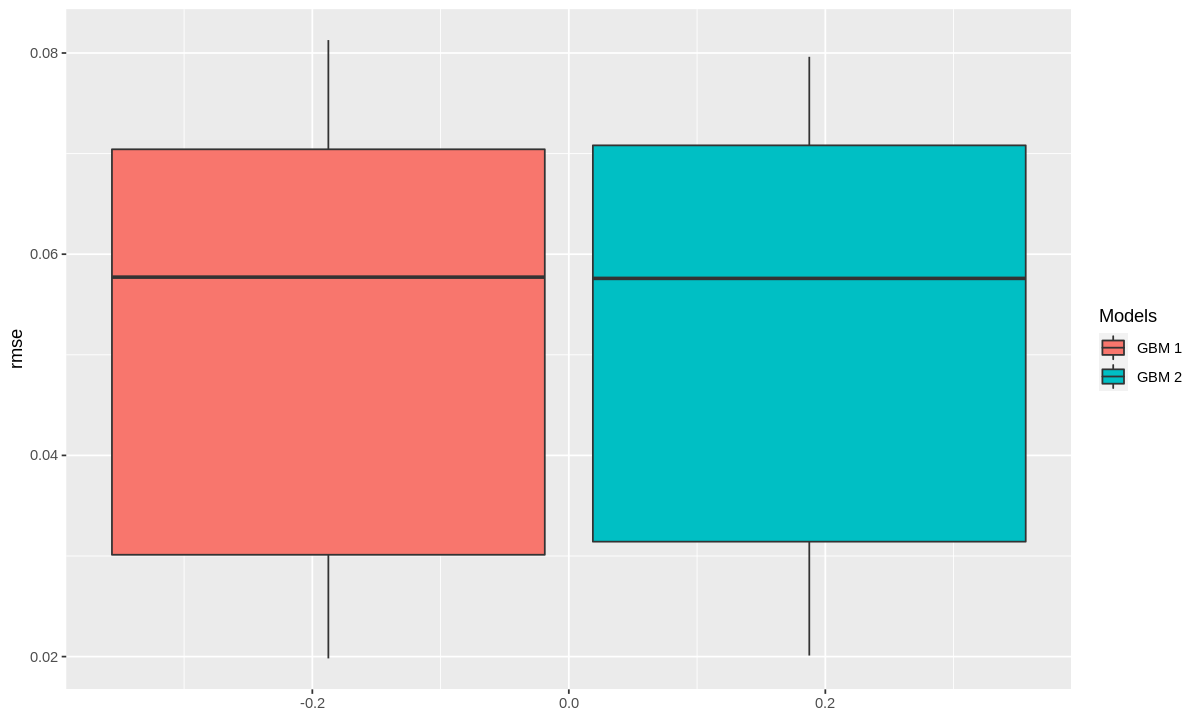

In [120]:
errors.1 <- my.get_result(result.m06.1, 'GBM 1')
errors.2 <- my.get_result(result.m06.2, 'GBM 2')

x <- rbind(errors.1, errors.2)

my.plot_errors(x, metrics=c('rmse'), loc='right')

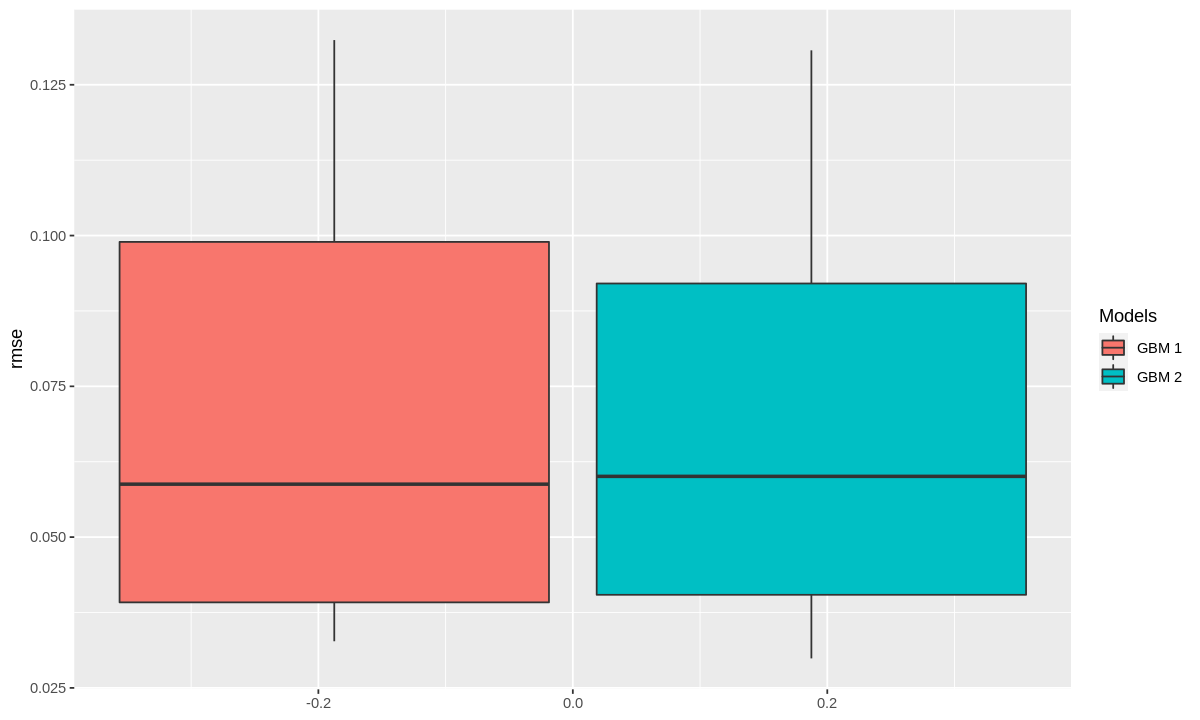

In [44]:
result.m06 <- result.m06.2

# Model Comparision

In [55]:
errors.1 <- my.get_result(result.m01, '1. Prophet')
errors.2 <- my.get_result(result.m02, '2. BSTS')
errors.3 <- my.get_result(result.m03, '3. ARIMA')
errors.4 <- my.get_result(result.m04, '4. ARIMA Errors')
errors.5 <- my.get_result(result.m05, '5. ARIMA+GARCH')
#errors.6 <- my.get_result(result.m06, '6. Gradient Boosting')

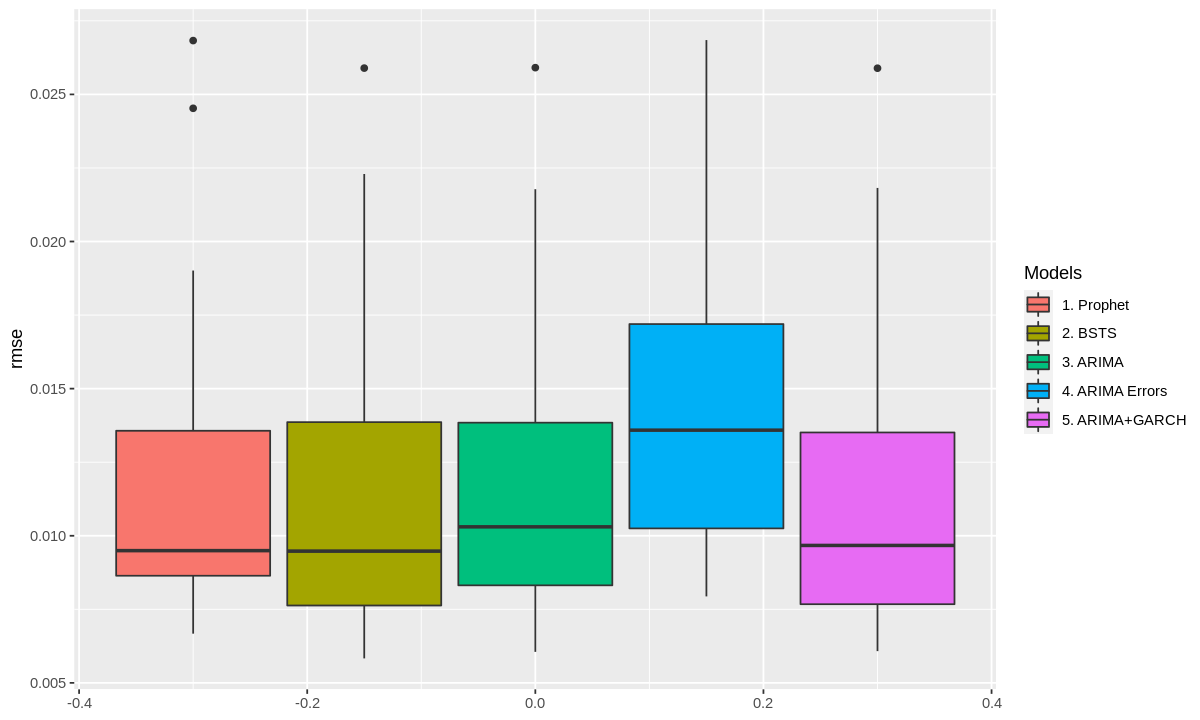

In [94]:
#errors.list <- list(errors.1, errors.2, errors.3, errors.4, errors.5, errors.6)
errors.list <- list(errors.1, errors.2, errors.3, errors.4, errors.5)
x <- errors.list[[1]]
for (e in errors.list[2:length(errors.list)]) {
    x <- rbind(x, e)
}

my.figsize(10, 6)
my.plot_errors(x, metrics=c('rmse'), loc='right')

In [92]:
#head(e)
#head(errors.list[1])
#rbind(errors.list[1], e)
#str(as.numeric(errors.list[1]))
str(errors.list[[1]])

'data.frame':	20 obs. of  3 variables:
 $ rmse: num  0.00784 0.00798 0.0067 0.00886 0.00889 ...
 $ mape: num  1.157 1.042 0.938 0.924 0.938 ...
 $ cs  : chr  "1. Prophet" "1. Prophet" "1. Prophet" "1. Prophet" ...
 - attr(*, "na.action")= 'omit' Named int [1:179] 1 2 3 4 5 6 7 8 9 10 ...
  ..- attr(*, "names")= chr [1:179] "1" "2" "3" "4" ...


In [80]:
str(e)

'data.frame':	24 obs. of  3 variables:
 $ rmse: num  0.01089 0.00893 0.00648 0.0072 0.00691 ...
 $ mape: num  1.209 1.001 0.975 1.271 1.399 ...
 $ cs  : chr  "2. BSTS" "2. BSTS" "2. BSTS" "2. BSTS" ...
 - attr(*, "na.action")= 'omit' Named int [1:178] 1 2 3 4 5 6 7 8 9 10 ...
  ..- attr(*, "names")= chr [1:178] "1" "2" "3" "4" ...


In [81]:
x <- list(1,2)

In [85]:
as.numeric(x[1])

[1] 1